# Part 1: Predictive Task

The goal of this project is to **predict the rating a user would give a Home & Kitchen product** based on their past interactions and review text. This is a **regression task**, where the target variable is the `rating` (a continuous value from 1 to 5).

## Input Features
- Review text (`text`)  
- Product metadata (`price`, `brand`, `category`)  
- User and product IDs for collaborative filtering  

## Output
- Predicted rating for a given user-product pair  

---

## Evaluation

We will evaluate model performance using:

- **Root Mean Squared Error (RMSE)** – measures the average magnitude of prediction errors.  
- **Mean Absolute Error (MAE)** – provides the average error in predicted ratings.  
- **Train/Test Split** – to simulate predicting future reviews, we will split the dataset chronologically or randomly.

These metrics are appropriate because they directly quantify how close predicted ratings are to the true ratings.

---

## Baseline Models

To benchmark performance, we will use **simple, course-relevant baselines**:

1. **Bias Terms (Global, User, Product averages)** – Predict the rating using overall averages and individual biases.  
2. **Collaborative Filtering (Surprise SVD)** – Factorizes the user-item matrix to predict missing ratings.  
3. **Optional Advanced Models** – Deep learning models on review text (e.g., RNNs or transformer-based embeddings) may be explored to improve predictions.

These baselines allow us to **quantify improvements** when moving from simple averages to more complex models.

---

## Validation

To assess the validity of predictions:

- **Cross-validation** – Split data into folds to check for overfitting.  
- **Comparison against baselines** – Any model must outperform simple bias-based predictors and SVD to be meaningful.  
- **Residual analysis** – Identify systematic errors for certain users, products, or rating ranges.

This ensures that our models are not only accurate on average but also **generalize well across the dataset**.


In [2]:
import json, gzip
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
i = 0
file = "Home_and_Kitchen.jsonl.gz"
with gzip.open(file, "rt", encoding="utf-8") as fp:
    for line in fp:
        if i > 30:
            break
        obj = json.loads(line)
        print(obj)
        i += 1
print(i)

{'rating': 1.0, 'title': 'Received Used & scratched item! Purchased new!', 'text': 'Livid.  Once again received an obviously used item that has food on it & scratches. I purchased this new!!  Pics not loading rn. Will add them later. Disgusted.', 'images': [], 'asin': 'B007WQ9YNO', 'parent_asin': 'B09XWYG6X1', 'user_id': 'AFKZENTNBQ7A7V7UXW5JJI6UGRYQ', 'timestamp': 1677373409298, 'helpful_vote': 1, 'verified_purchase': True}
{'rating': 5.0, 'title': 'Excellent for moving & storage & floods!', 'text': 'I purchased these for multiple reasons. The main reason was that I was moving. I was moving bc my apt kept flooding.  Luckily having been through other floods I generally store all my stuff in plastic containers anyways. Sadly a couple of my vintage Singer’s in wooden boxes had been left out during the last move & the last flood got them moldy & ruined them.  I am a bibliophile & these bags held not only huge stacks of my hardcover books, but my 40 pound Singer sewing machines. I also car

# Part 2: Exploratory Data Analysis (EDA)

## Dataset Overview and Context
We focus on the **Home & Kitchen subset** of the Amazon Reviews 2023 dataset, sampled to **5,000,001 reviews** and **50,001 product metadata records**.

### Key Data Fields:
* **Reviews:** `rating`, `text`, `user_id`, `asin` / `parent_asin`, `timestamp`, `helpful_vote`, `verified_purchase`.
* **Metadata:** `price`, `brand`, `categories`.

---

## Review Statistics and Distribution

### Rating Bias
The dataset exhibits a **strong positive bias**, typical of e-commerce platforms.
* The **5-star rating is overwhelmingly dominant** with **3.44 million** reviews.
* This positive skew mandates the use of **RMSE** and **MAE** (rather than accuracy) to quantify meaningful improvements over simple baselines.



[Image of Rating Distribution]


### Review Length
* **Distribution:** Heavily right-skewed; most reviews are under 80 words.
* **Length vs. Rating:** Longer reviews are generally found for mid-range ratings (2, 3, 4), while 5-star reviews are often concise. The overall linear correlation between `rating` and `text_length` is weak ($\rho = -0.10$).

---

## User and Product Sparsity

The data presents significant sparsity, a key challenge for collaborative filtering methods.

* **Sparsity:** A high percentage of both users and products have only one review.
* This **"cold-start" problem** means that many interactions lack sufficient history for pure Collaborative Filtering models (like SVD) to make accurate predictions.

---

## Temporal Trends and Validation Split

* **Growth:** Review volume grew steadily from 2012, peaking around **2021** (over 800,000 reviews).
* **Implication:** This trend validates the plan to use a **chronological Train/Test Split** to simulate real-world prediction, where the model must generalize to future user behavior.



---

## Product Metadata Analysis

### Price and Rating Relationship
* **Price Distribution:** Most products are concentrated in the lower price range (under **\$80**), with a long tail extending to higher values.
* **Price vs. Average Rating:** The scatter plot shows **no strong visible correlation** between product price and average rating. High average ratings (4.5–5.0) are observed consistently across nearly all price points. **Price is unlikely to be a primary predictor** of rating on its own.



### Feature Correlation
A correlation heatmap of numeric features shows:
* The correlation between `helpful_vote` and `rating` is negligible ($\rho = -0.02$).
* The strongest relationship is a weak positive correlation between `helpful_vote` and `text_length` ($\rho = 0.15$).



---

## Summary for Modeling

The EDA confirms the need for a **Hybrid Modeling Approach** (Part 3) to overcome data limitations:

1.  **Collaborative Filtering (CF):** Required to handle **user and item IDs** in the sparse matrix.
2.  **Content-Based:** Necessary to leverage the rich information in the **Review Text** and **Metadata** (price, brand) to address the cold-start problem and improve predictions where CF is weak.

In [3]:
reviews = []
with gzip.open(file, "rt", encoding="utf-8") as fp:
    for i, line in enumerate(fp):
        reviews.append(json.loads(line))
        if i >= 5000000:
            break

df = pd.DataFrame(reviews)
df.head()


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,1.0,Received Used & scratched item! Purchased new!,Livid. Once again received an obviously used ...,[],B007WQ9YNO,B09XWYG6X1,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1677373409298,1,True
1,5.0,Excellent for moving & storage & floods!,I purchased these for multiple reasons. The ma...,[],B09H2VJW6K,B0BXDLF8TW,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1672043410846,0,True
2,2.0,Lid very loose- needs a gasket imo. Small base.,[[VIDEOID:c87e962bc893a948856b0f1b285ce6cc]] I...,[{'small_image_url': 'https://m.media-amazon.c...,B07RL297VR,B09G2PW8ZG,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1653447296788,0,True
3,5.0,Best purchase ever!,If you live at a higher elevation like me (5k ...,[{'small_image_url': 'https://m.media-amazon.c...,B09CQF4SWV,B08CSZDXZY,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1651855096178,0,True
4,5.0,Excellent for yarn!,I use these to store yarn. They easily hold 12...,[{'small_image_url': 'https://images-na.ssl-im...,B003U6A3EY,B0C6V27S6N,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1589934525940,1,True


In [ ]:
print(f"Loaded {len(df):,} reviews")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nRating distribution:")
print(df['rating'].value_counts().sort_index())

Loaded 5,000,001 reviews

Columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

Data types:
rating               float64
title                 object
text                  object
images                object
asin                  object
parent_asin           object
user_id               object
timestamp              int64
helpful_vote           int64
verified_purchase       bool
dtype: object

Missing values:
rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64

Rating distribution:
rating
1.0     361660
2.0     219631
3.0     355427
4.0     628002
5.0    3435281
Name: count, dtype: int64


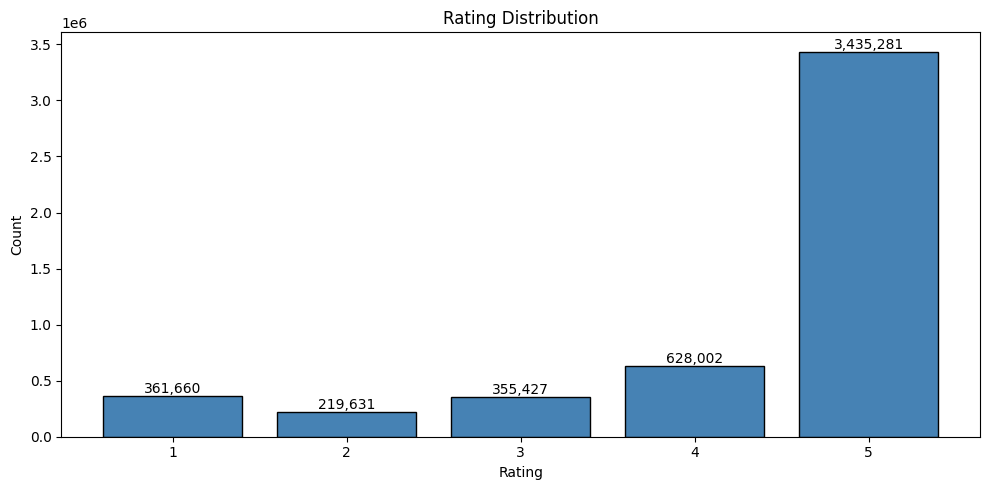

First 100k reviews:
rating
1.0    0.05430
2.0    0.03639
3.0    0.06860
4.0    0.14484
5.0    0.69587
Name: proportion, dtype: float64

Last 100k reviews:
rating
1.0    0.07389
2.0    0.04215
3.0    0.06856
4.0    0.11245
5.0    0.70295
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(10, 5))
rating_counts = df['rating'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values, color='steelblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
for i, v in zip(rating_counts.index, rating_counts.values):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


print("First 100k reviews:")
df_early = pd.DataFrame(reviews[:100000])
print(df_early['rating'].value_counts(normalize=True).sort_index())

print("\nLast 100k reviews:")
df_late = pd.DataFrame(reviews[-100000:])
print(df_late['rating'].value_counts(normalize=True).sort_index())


Review length stats (words):
count    5.000001e+06
mean     3.921665e+01
std      5.643618e+01
min      0.000000e+00
25%      1.000000e+01
50%      2.300000e+01
75%      4.700000e+01
max      4.023000e+03
Name: text_length, dtype: float64


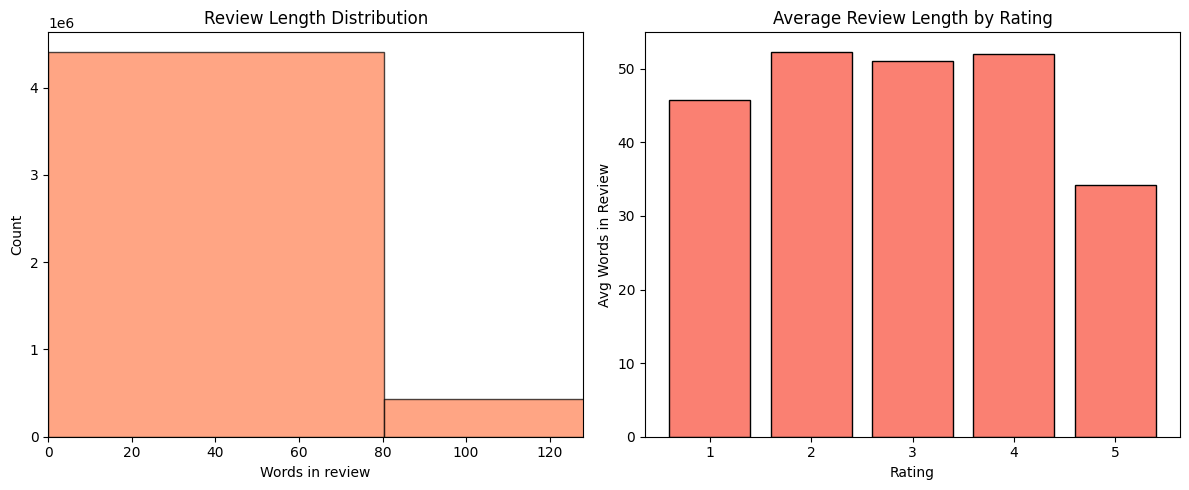


655,389 unique users
1,420,467 unique products
Avg reviews per user: 7.63
Avg reviews per product: 3.52

Users with only 1 review: 144,145 (22.0%)
Products with only 1 review: 836,759 (58.9%)

Top 10 most reviewed products:
asin
B013R3Q7B2    5199
B00FLYWNYQ    4915
B001EYHAGS    3439
B07547PTX8    3229
B01CX1RIMQ    3160
B00DDXWFY0    2733
B005YR0F40    2536
B00BC0SPIQ    2533
B002IT6E6A    2375
B00ZOH2J5I    2243
Name: count, dtype: int64

Reviews by year:
year
2000        48
2001        89
2002       158
2003       299
2004       385
2005       720
2006      1240
2007      2947
2008      3712
2009      5323
2010     10149
2011     19043
2012     35846
2013     96172
2014    172281
2015    278933
2016    380659
2017    417141
2018    483036
2019    651736
2020    770683
2021    808739
2022    694010
2023    166652
Name: count, dtype: int64


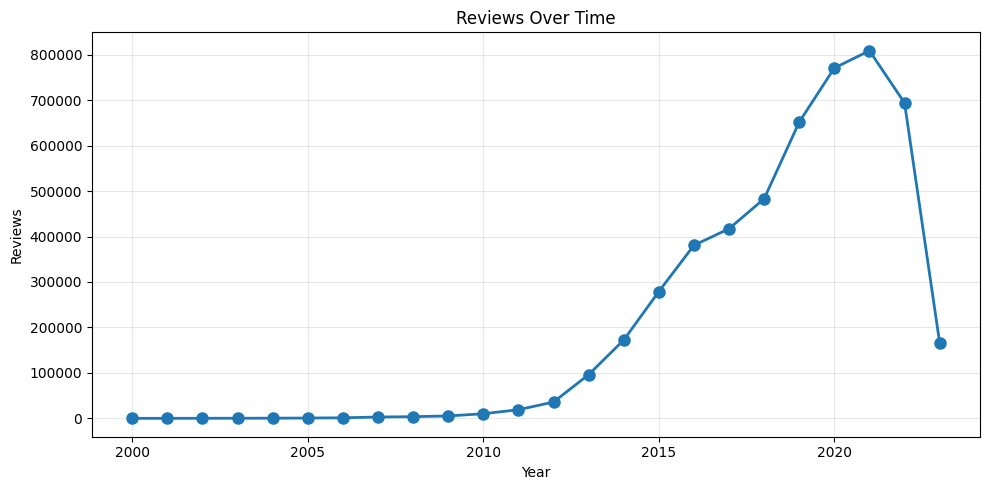


Helpful votes by rating:
rating
1.0    2.38
2.0    1.36
3.0    1.25
4.0    1.30
5.0    1.01
Name: helpful_vote, dtype: float64


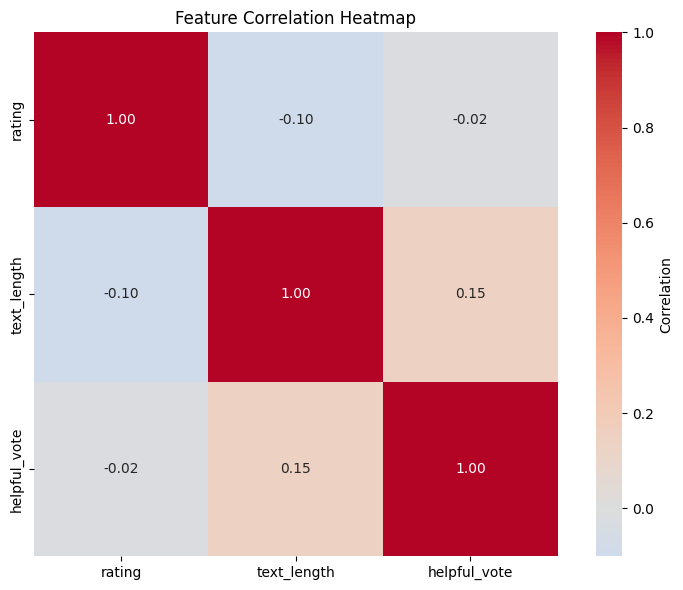

In [ ]:
# Review text analysis
df['text_length'] = df['text'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)
print(f"\nReview length stats (words):\n{df['text_length'].describe()}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50, color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('Words in review')
plt.ylabel('Count')
plt.title('Review Length Distribution')
plt.xlim(0, df['text_length'].quantile(0.95))

plt.subplot(1, 2, 2)
avg_length_by_rating = df.groupby('rating')['text_length'].mean()
plt.bar(avg_length_by_rating.index, avg_length_by_rating.values, color='salmon', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Avg Words in Review')
plt.title('Average Review Length by Rating')

plt.tight_layout()
plt.show()

# User and product statistics
n_users = df['user_id'].nunique()
n_products = df['asin'].nunique()

print(f"\n{n_users:,} unique users")
print(f"{n_products:,} unique products")
print(f"Avg reviews per user: {len(df)/n_users:.2f}")
print(f"Avg reviews per product: {len(df)/n_products:.2f}")

# Sparsity analysis
user_counts = df['user_id'].value_counts()
product_counts = df['asin'].value_counts()

print(f"\nUsers with only 1 review: {(user_counts == 1).sum():,} ({(user_counts == 1).sum()/n_users*100:.1f}%)")
print(f"Products with only 1 review: {(product_counts == 1).sum():,} ({(product_counts == 1).sum()/n_products*100:.1f}%)")

print(f"\nTop 10 most reviewed products:")
print(product_counts.head(10))

# Temporal trends
if 'timestamp' in df.columns:
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['year'] = df['date'].dt.year
    
    yearly = df['year'].value_counts().sort_index()
    print(f"\nReviews by year:")
    print(yearly)
    
    plt.figure(figsize=(10, 5))
    plt.plot(yearly.index, yearly.values, marker='o', linewidth=2, markersize=8)
    plt.xlabel('Year')
    plt.ylabel('Reviews')
    plt.title('Reviews Over Time')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Helpfulness
if 'helpful_vote' in df.columns:
    print(f"\nHelpful votes by rating:")
    print(df.groupby('rating')['helpful_vote'].mean().round(2))

# Correlation heatmap
numeric_cols = ['rating', 'text_length']
if 'helpful_vote' in df.columns:
    numeric_cols.append('helpful_vote')

corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

- Metadata Analysis

In [ ]:
# Load metadata
meta_file = "meta_Home_and_Kitchen.jsonl.gz"
metadata = []

with gzip.open(meta_file, "rt", encoding="utf-8") as fp:
    for i, line in enumerate(fp):
        metadata.append(json.loads(line))
        if i >= 50000:  
            break

meta_df = pd.DataFrame(metadata)
meta_df.head()

print(f"\nLoaded {len(meta_df):,} products")
print(f"Columns: {list(meta_df.columns)}")
print(f"\nData types:\n{meta_df.dtypes}")
print(f"\nMissing values:\n{meta_df.isnull().sum()}")


Loaded 50,001 products
Columns: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together']

Data types:
main_category       object
title               object
average_rating     float64
rating_number        int64
features            object
description         object
price              float64
images              object
videos              object
store               object
categories          object
details             object
parent_asin         object
bought_together     object
dtype: object

Missing values:
main_category       1289
title                  0
average_rating         0
rating_number          0
features               0
description            0
price              24588
images                 0
videos                 0
store                872
categories             0
details                0
parent_asin            0
bought_together    50001
dtype: in

Metadata columns: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together']

Price statistics:
count    25413.000000
mean        52.260023
std        132.257010
min          0.260000
25%         14.210000
50%         22.990000
75%         42.990000
max       4289.000000
Name: price_clean, dtype: float64


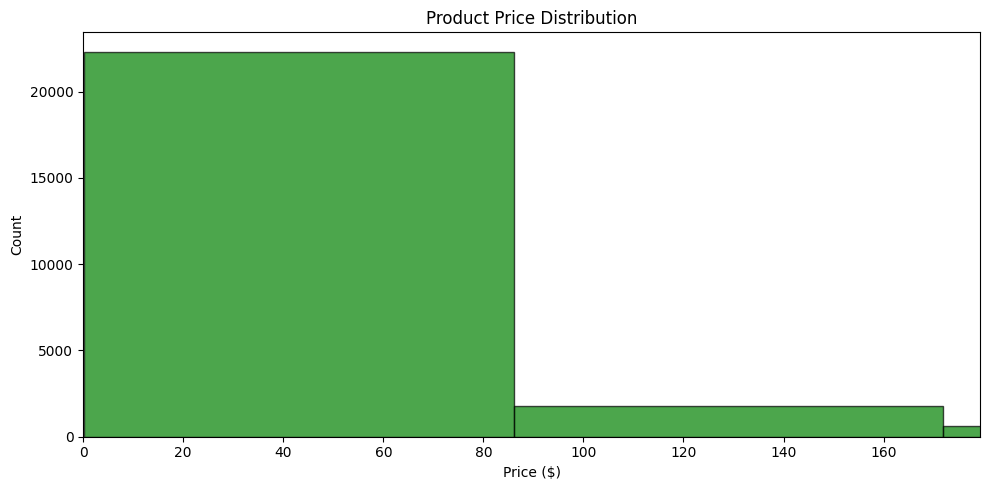


Merged 8,923 products with review data


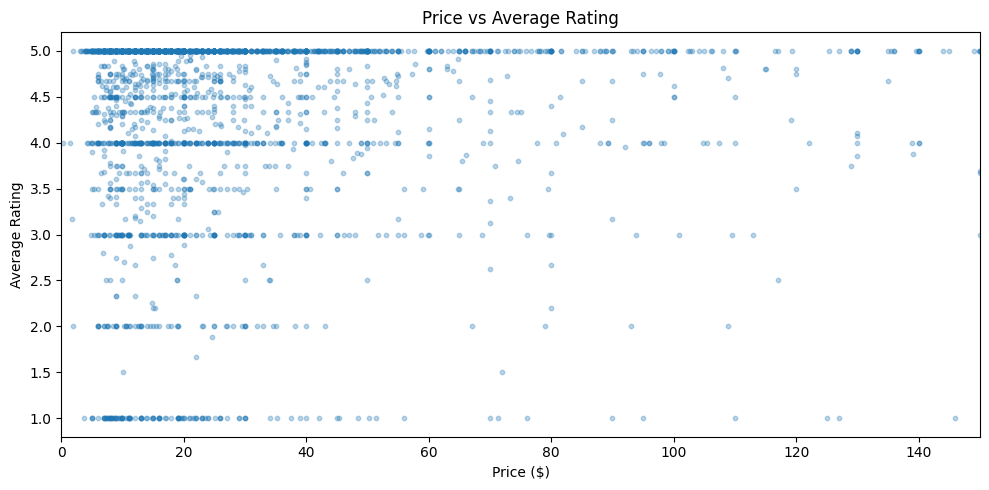

In [ ]:
print(f"Metadata columns: {list(meta_df.columns)}")

# Price analysis
if 'price' in meta_df.columns:
    meta_df['price_clean'] = pd.to_numeric(meta_df['price'], errors='coerce')
    print(f"\nPrice statistics:")
    print(meta_df['price_clean'].describe())
    
    plt.figure(figsize=(10, 5))
    plt.hist(meta_df['price_clean'].dropna(), bins=50, color='green', edgecolor='black', alpha=0.7)
    plt.xlabel('Price ($)')
    plt.ylabel('Count')
    plt.title('Product Price Distribution')
    plt.xlim(0, meta_df['price_clean'].quantile(0.95))
    plt.tight_layout()
    plt.show()

# Category analysis
if 'categories' in meta_df.columns:
    all_categories = []
    for cats in meta_df['categories'].dropna():
        if isinstance(cats, list):
            for cat_list in cats:
                if isinstance(cat_list, list):
                    all_categories.extend(cat_list)
    
    if len(all_categories) > 0:
        cat_counts = Counter(all_categories)
        top_cats = cat_counts.most_common(10)
        
        print(f"\nTop 10 categories:")
        for cat, count in top_cats:
            print(f"{cat}: {count:,}")
        
        plt.figure(figsize=(12, 6))
        cats, counts = zip(*top_cats)
        plt.barh(range(len(cats)), counts, color='purple', edgecolor='black')
        plt.yticks(range(len(cats)), cats)
        plt.xlabel('Number of Products')
        plt.title('Top Product Categories')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

elif 'main_category' in meta_df.columns:
    print(f"\nTop categories:")
    print(meta_df['main_category'].value_counts().head(10))

# Brand analysis  
if 'brand' in meta_df.columns:
    print(f"\nTop 10 brands:")
    print(meta_df['brand'].value_counts().head(10))

# Merge with reviews
product_id_col = 'parent_asin' if 'parent_asin' in meta_df.columns else 'asin'

if product_id_col in meta_df.columns:
    product_stats = df.groupby('asin').agg({
        'rating': 'mean',
        'text_length': 'mean'
    }).reset_index()
    product_stats.columns = ['asin', 'avg_rating', 'avg_text_length']
    
    merged = meta_df.merge(product_stats, left_on=product_id_col, right_on='asin', how='inner')
    print(f"\nMerged {len(merged):,} products with review data")
    
    # Price vs rating
    if 'price_clean' in merged.columns:
        plt.figure(figsize=(10, 5))
        plt.scatter(merged['price_clean'], merged['avg_rating'], alpha=0.3, s=10)
        plt.xlabel('Price ($)')
        plt.ylabel('Average Rating')
        plt.title('Price vs Average Rating')
        plt.xlim(0, merged['price_clean'].quantile(0.95))
        plt.tight_layout()
        plt.show()

Part 3 - Rating Prediction
-> What will a user rate a given item based on their past reviews?

In [56]:
# --------------------
# Neural Collaborative Filtering (NCF) on 20k samples
# --------------------

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# --------------------
# 1. Sample 20k reviews and split
# --------------------
SAMPLE_N = 20000
df_sample = df.sample(n=min(SAMPLE_N, len(df)), random_state=42)

train_val, test_df = train_test_split(df_sample, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val, test_size=0.2, random_state=42)

# Encode users and items
user_le = LabelEncoder()
item_le = LabelEncoder()
user_le.fit(train_df['user_id'].astype(str))
item_le.fit(train_df['asin'].astype(str))

def encode_safe(le, series):
    mapping = {v: i+1 for i, v in enumerate(le.classes_)}
    return series.map(mapping).fillna(0).astype(int)

for d in [train_df, val_df, test_df]:
    d['user_idx'] = encode_safe(user_le, d['user_id'])
    d['item_idx'] = encode_safe(item_le, d['asin'])

N_USERS = len(user_le.classes_) + 1
N_ITEMS = len(item_le.classes_) + 1

In [57]:
# --------------------
# 2. Text embeddings (optional)
# --------------------
from sentence_transformers import SentenceTransformer

USE_TEXT = True
TEXT_EMB_DIM = 384  # MiniLM default
if USE_TEXT:
    text_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    item_texts = {}
    for asin, group in train_df.groupby('asin'):
        parts = []
        if 'title' in group.columns:
            title = group['title'].dropna().astype(str)
            if len(title): parts.append(title.iloc[0])
        if 'reviewText' in group.columns:
            review = group['reviewText'].dropna().astype(str)
            if len(review): parts.append(review.iloc[0])
        item_texts[asin] = " ".join(parts) if parts else ""
    
    ordered_texts = [item_texts.get(item_le.inverse_transform([i-1])[0], "")
                     for i in range(1, N_ITEMS)]
    embeddings = text_model.encode(ordered_texts, convert_to_numpy=True)
    item_text_matrix = torch.tensor(
        np.vstack([np.zeros((1, embeddings.shape[1])), embeddings]),
        dtype=torch.float32
    )
else:
    item_text_matrix = None

In [59]:
# --------------------
# 3. Dataset and DataLoader
# --------------------
class BPRDataset(Dataset):
    def __init__(self, df, n_items):
        self.user_idx = df['user_idx'].values
        self.item_idx = df['item_idx'].values
        self.n_items = n_items

    def __len__(self):
        return len(self.user_idx)

    def __getitem__(self, idx):
        u = self.user_idx[idx]
        i = self.item_idx[idx]
        # negative sampling
        j = np.random.randint(1, self.n_items)
        while j == i:
            j = np.random.randint(1, self.n_items)
        return (
            torch.tensor(u, dtype=torch.long),
            torch.tensor(i, dtype=torch.long),
            torch.tensor(j, dtype=torch.long)
        )

train_dataset = BPRDataset(train_df, N_ITEMS)
val_dataset = BPRDataset(val_df, N_ITEMS)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024)

In [60]:
# --------------------
# 4. NCF model
# --------------------
class NCF(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, text_emb=None):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        self.text_emb = text_emb
        if text_emb is not None:
            self.text_proj = nn.Linear(text_emb.shape[1], emb_dim)
        else:
            self.text_proj = None

        self.fc_layers = nn.Sequential(
            nn.Linear(emb_dim*2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, u, i):
        u_e = self.user_emb(u)
        i_e = self.item_emb(i)
        if self.text_emb is not None:
            i_text = self.text_proj(self.text_emb[i])
            i_e = i_e + i_text
        x = torch.cat([u_e, i_e], dim=1)
        score = self.fc_layers(x).squeeze()
        return score

In [61]:
# --------------------
# 5. Training setup
# --------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NCF(N_USERS, N_ITEMS, emb_dim=64, text_emb=item_text_matrix.to(device) if USE_TEXT else None).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()
EPOCHS = 3

In [62]:
# --------------------
# 6. Training loop
# --------------------
for ep in range(EPOCHS):
    model.train()
    total_loss = 0
    for u, i, j in train_loader:
        u, i, j = u.to(device), i.to(device), j.to(device)
        optimizer.zero_grad()

        # positive sample
        pos_score = model(u, i)
        # negative sample
        neg_score = model(u, j)

        # BPR-style loss using BCE with logits
        labels = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)])
        scores = torch.cat([pos_score, neg_score])
        loss = criterion(scores, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * u.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {ep+1} | BCE Loss: {avg_loss:.4f}")

Epoch 1 | BCE Loss: 0.6941
Epoch 2 | BCE Loss: 0.6925
Epoch 3 | BCE Loss: 0.6916


In [63]:
# --------------------
# 7. Top-N recommendation for 5 random users (title + text)
# --------------------
def top_n_with_text(model, user_idx, N=5, device='cpu'):
    model.eval()
    u = torch.tensor([user_idx]*(N_ITEMS), dtype=torch.long).to(device)
    i = torch.arange(N_ITEMS, dtype=torch.long).to(device)
    with torch.no_grad():
        scores = model(u, i)
    top_idx = torch.topk(scores, N).indices.cpu().numpy()
    return [item_le.inverse_transform([idx-1])[0] for idx in top_idx if idx != 0]


In [64]:
# Test
import random

# Pick 5 random users from the train set
sample_users = random.sample(list(train_df['user_id'].unique()), 5)
N = 5  # top-N items

for user_str in sample_users:
    print(f"User: {user_str}")
    user_idx = user_le.transform([user_str])[0] + 1  # map to embedding index

    top_asins = top_n(model, user_idx, N=N, device=device)
    for asin in top_asins:
        title = df.loc[df['asin'] == asin, 'title'].values
        title = title[0] if len(title) > 0 else "Unknown"

        review = df.loc[df['asin'] == asin, 'text'].values
        review = review[0] if len(review) > 0 else ""

        full_text = f"{title} | {review}" if review else title
        print(f"  ASIN: {asin}, Title + Text: {full_text}")
    print()

User: AGHZI4SMSY7CMMY4IOBSYE5AZ5QA
  ASIN: B07WSLK43Y, Title + Text: A very fast and reliable cleaning robot | This Coredy R3500S robot is much faster than my iRobot Roomba. It also cleans much longer, 2 hours of cleaning! You don't need the sensor device to block it from going down stairs like my old machine did either. It also slows down when approaching furniture or cabinets so that it won't cause any damage. I love the lower profile, it goes under my couch and kitchen cabinets for a thorough cleaning. I can't find a thing wrong with it. It does an amazing job picking up the dog hair left by my 4 dogs, one being a very hairy husky who sheds like crazy! I am buying this same robot for my daughter for Christmas after seeing what an amazing job it does on my floors! If it tore up today, I would buy the same product tomorrow.
  ASIN: B0964LGQ74, Title + Text: Beautiful | ::Product::<br />I usually buy flowers for my mom on her birthday but this time I found this rose that will last long